# Sentinel-2 Autoencoder and Clustering

## Download the EuroSAT dataset


[EuroSAT dataset](https://github.com/phelber/EuroSAT)
![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)


Download the dataset

In [1]:
import requests

url =  'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
r = requests.get(url, allow_redirects=True)
open('EuroSAT.zip', 'wb').write(r.content)

94280567

Unzip the dataset

In [ ]:
!unzip '/content/EuroSAT.zip'

Rename the folder

In [3]:
!mv '/content/2750' '/content/EuroSAT'

Count images in the dataset

In [4]:
import glob

paths = glob.glob('/content/EuroSAT/*/*')
print('Number of images {}/27000'.format(len(paths)))

Number of images 27000/27000


## Image Data Generator 

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='input',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='input',
    subset='validation')  

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [6]:
classes = train_generator.class_indices
classes= dict(zip(classes.values(), classes.keys()))  
print(classes)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


Generate some exaples

In [7]:
x,y = next(iter(train_generator))
print('x shape {}'.format(x.shape))
print('y shape {}'.format(y.shape))

x shape (16, 64, 64, 3)
y shape (16, 64, 64, 3)


Plot some examples

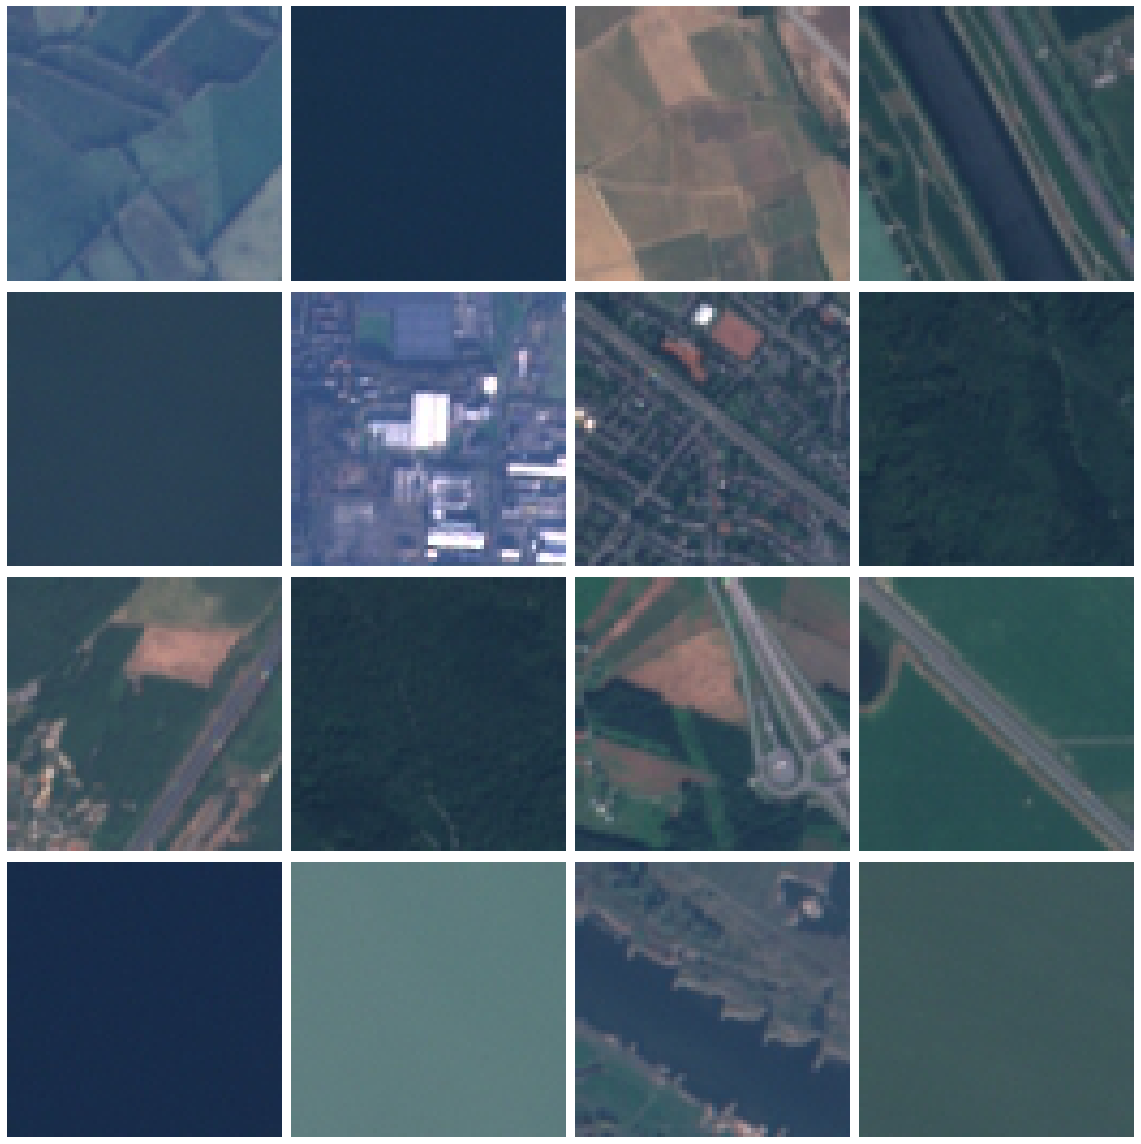

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16,16))

ct = 0
for i in range(4):
  for j in range(4):
    axes[i,j].imshow(x[ct])
    axes[i,j].axis(False)
    ct += 1

fig.tight_layout()
plt.show()


## Define the Autoencoder


In [9]:
from re import X
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D


model = None
input_img = Input(shape=(64, 64, 3)) 

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, x)

Compile the model

In [10]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

Print model configuration

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496 

## Train the autoencoder

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//batch_size,
    epochs = 15
)

Epoch 1/15
1350/1350 [==============================] - 40s 21ms/step - loss: 0.0038 - mae: 0.0380 - val_loss: 0.0024 - val_mae: 0.0301
Epoch 2/15
1350/1350 [==============================] - 26s 19ms/step - loss: 0.0021 - mae: 0.0284 - val_loss: 0.0019 - val_mae: 0.0260
Epoch 3/15
1350/1350 [==============================] - 25s 19ms/step - loss: 0.0019 - mae: 0.0268 - val_loss: 0.0017 - val_mae: 0.0250
Epoch 4/15
1350/1350 [==============================] - 25s 19ms/step - loss: 0.0017 - mae: 0.0255 - val_loss: 0.0016 - val_mae: 0.0235
Epoch 5/15
1350/1350 [==============================] - 25s 19ms/step - loss: 0.0016 - mae: 0.0247 - val_loss: 0.0015 - val_mae: 0.0235
Epoch 6/15
1350/1350 [==============================] - 25s 18ms/step - loss: 0.0015 - mae: 0.0239 - val_loss: 0.0015 - val_mae: 0.0241
Epoch 7/15
1350/1350 [==============================] - 24s 18ms/step - loss: 0.0015 - mae: 0.0235 - val_loss: 0.0014 - val_mae: 0.0227
Epoch 8/15
1350/1350 [==========================

Plot training history

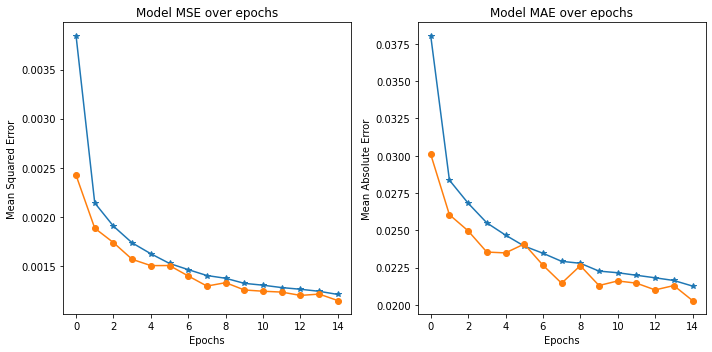

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

axes[0].plot(history.history['loss'], '-*', label = 'Training')
axes[0].plot(history.history['val_loss'], '-o', label = 'Validtion')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Model MSE over epochs')

axes[1].plot(history.history['mae'], '-*', label = 'Training')
axes[1].plot(history.history['val_mae'], '-o', label = 'Validtion')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Model MAE over epochs')

fig.tight_layout()
plt.show()

## Evaluate Results

In [13]:
x, y = next(iter(val_generator))
y_pred = model.predict(x)

	 --------------------------- Batch 0 ---------------------------


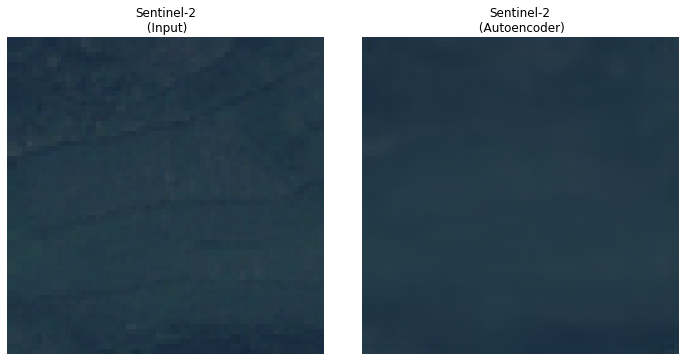

	 --------------------------- Batch 1 ---------------------------


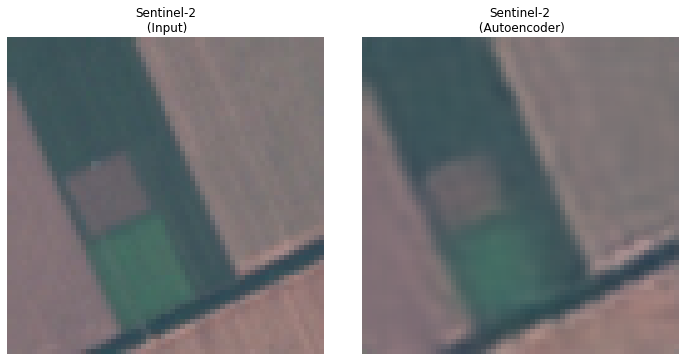

	 --------------------------- Batch 2 ---------------------------


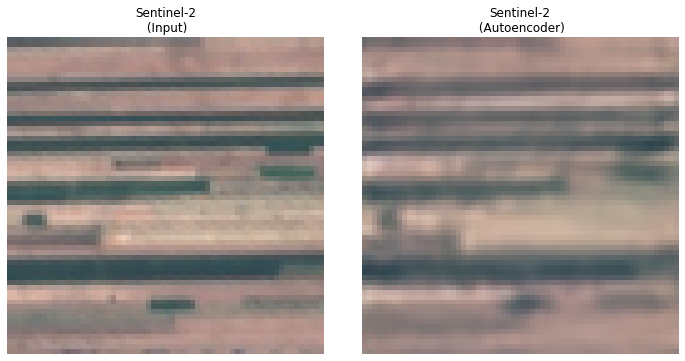

	 --------------------------- Batch 3 ---------------------------


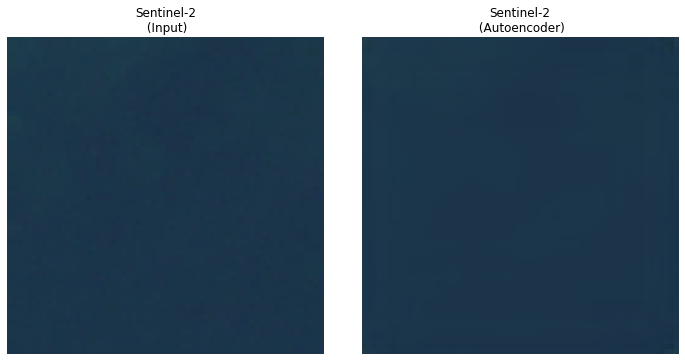

	 --------------------------- Batch 4 ---------------------------


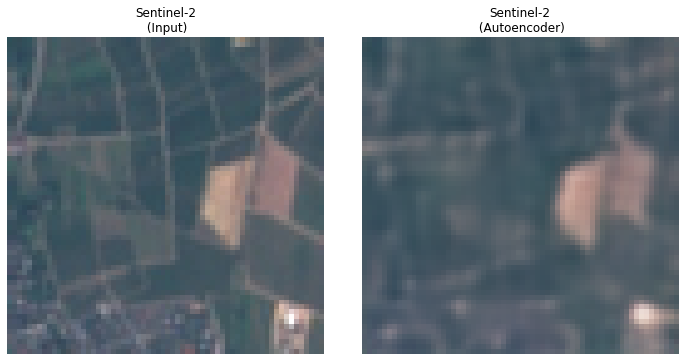

	 --------------------------- Batch 5 ---------------------------


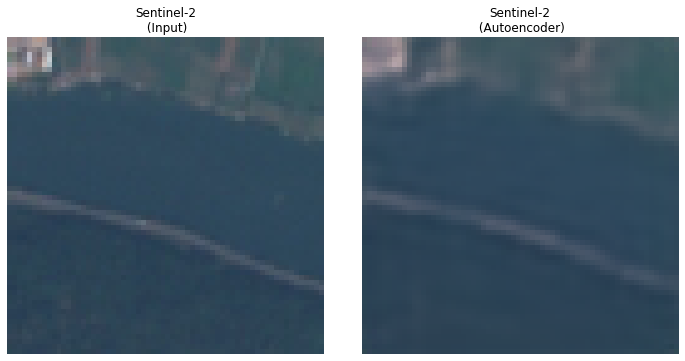

	 --------------------------- Batch 6 ---------------------------


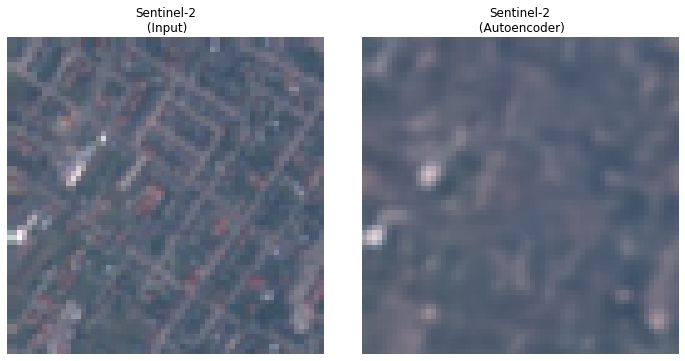

	 --------------------------- Batch 7 ---------------------------


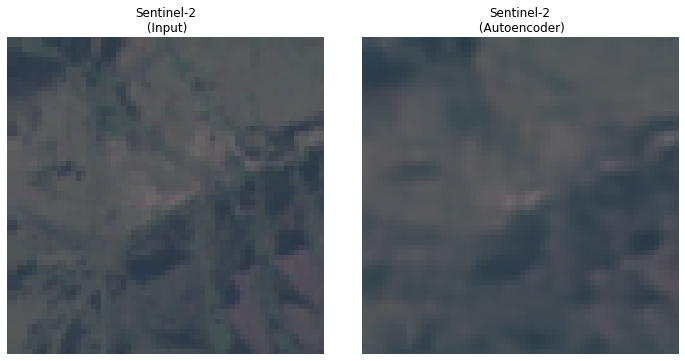

	 --------------------------- Batch 8 ---------------------------


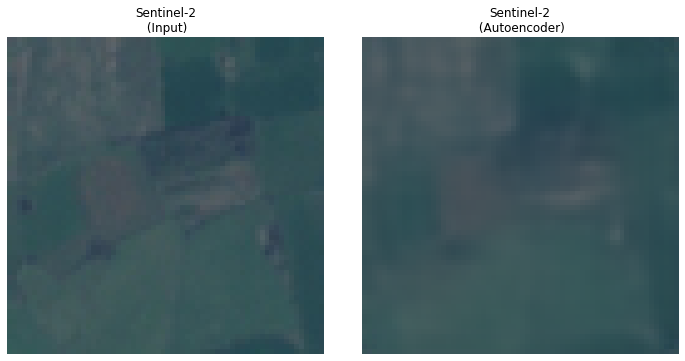

	 --------------------------- Batch 9 ---------------------------


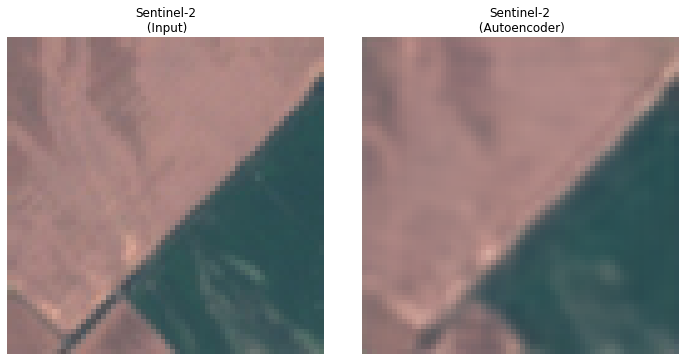

	 --------------------------- Batch 10 ---------------------------


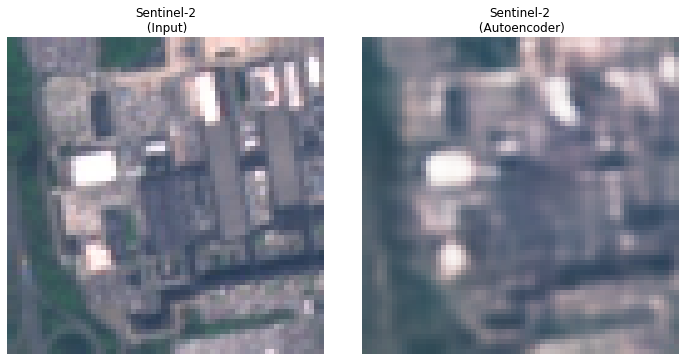

	 --------------------------- Batch 11 ---------------------------


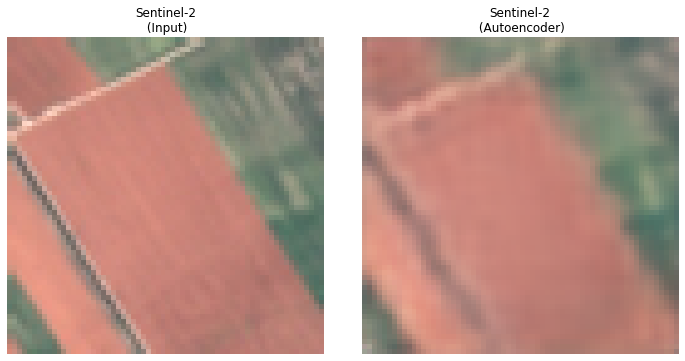

	 --------------------------- Batch 12 ---------------------------


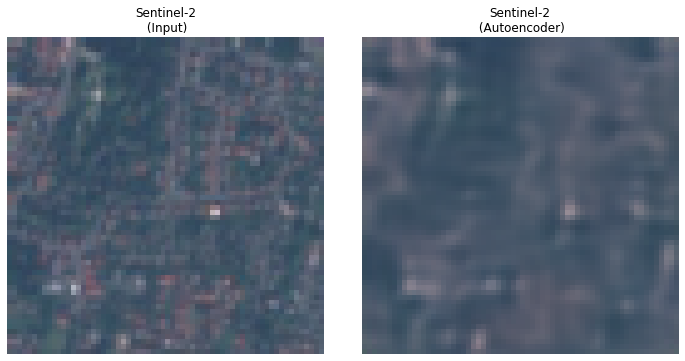

	 --------------------------- Batch 13 ---------------------------


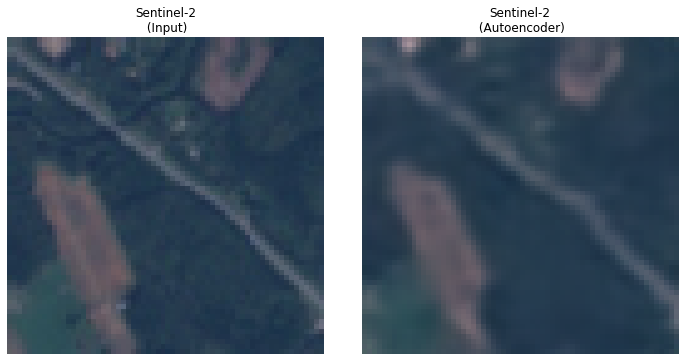

	 --------------------------- Batch 14 ---------------------------


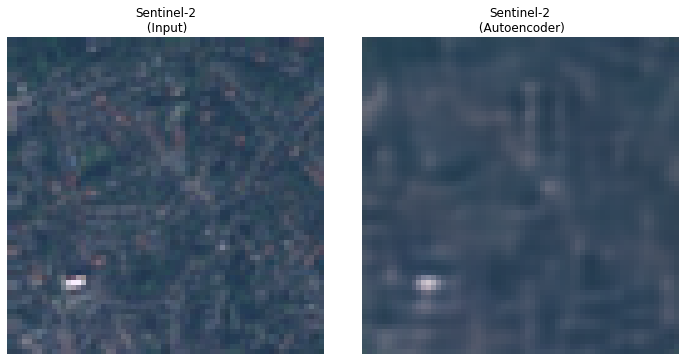

	 --------------------------- Batch 15 ---------------------------


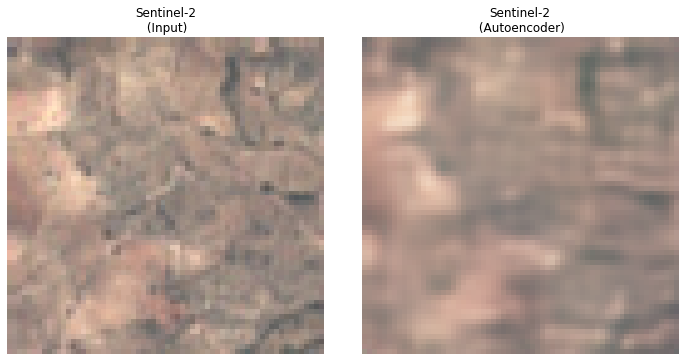

In [14]:
for i in range(batch_size):
  print('\t --------------------------- Batch {} ---------------------------'.format(i))

  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
  axes[0].imshow(x[i])
  axes[0].axis(False)
  axes[0].set_title('Sentinel-2\n (Input)')

  axes[1].imshow(y_pred[i])
  axes[1].axis(False)
  axes[1].set_title('Sentinel-2\n (Autoencoder)')

  fig.tight_layout()
  plt.show()
  plt.close()

## Get access to features

In [15]:
encoder = Model(inputs=model.input, outputs=model.layers[6].output)

In [18]:
y_encoder = encoder.predict(x)

							 --------------------------- Batch 0 --------------------------- 



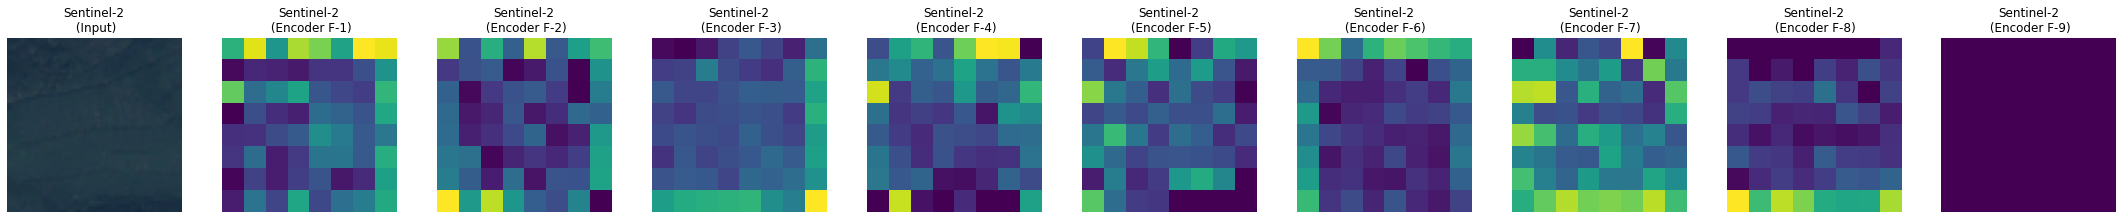

							 --------------------------- Batch 1 --------------------------- 



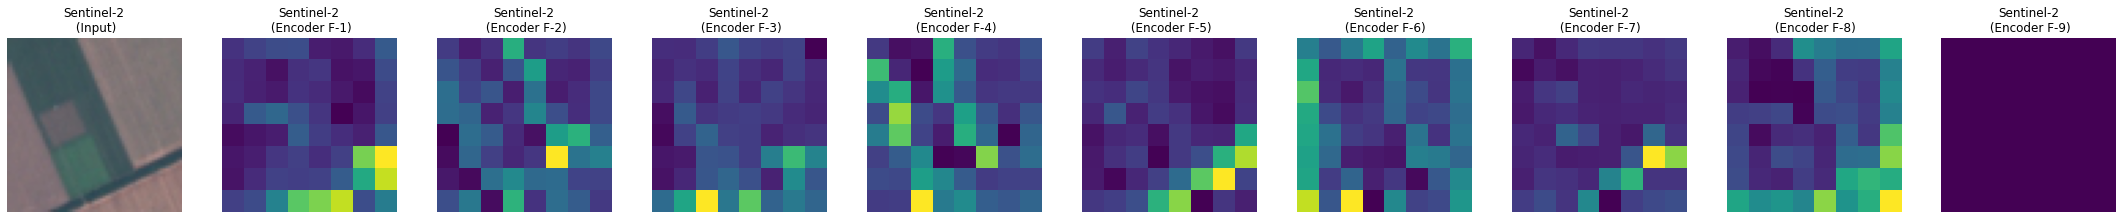

							 --------------------------- Batch 2 --------------------------- 



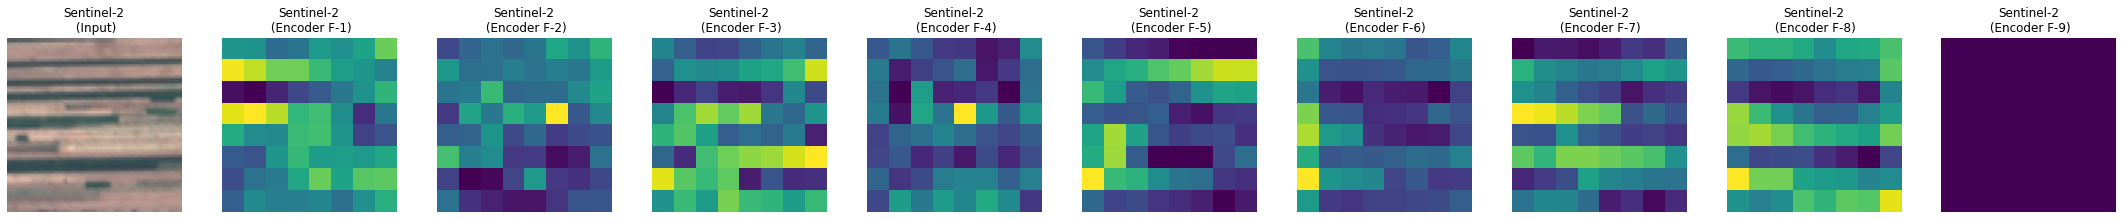

							 --------------------------- Batch 3 --------------------------- 



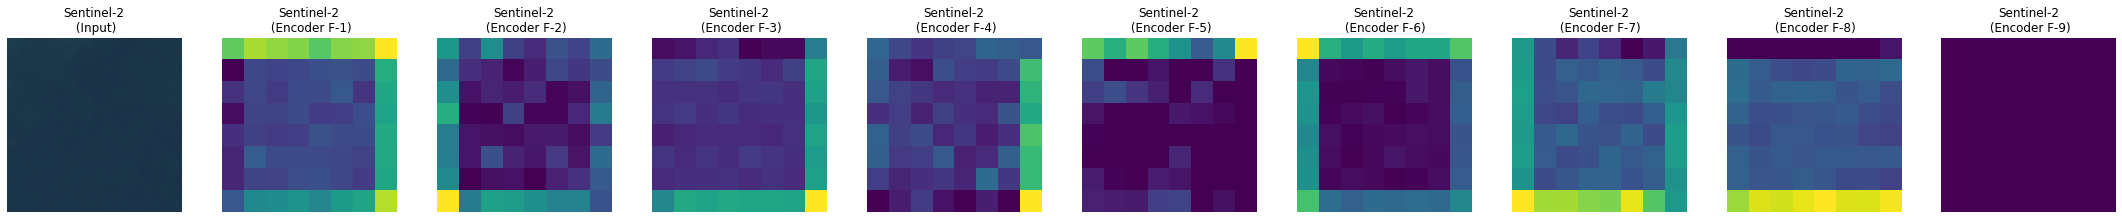

							 --------------------------- Batch 4 --------------------------- 



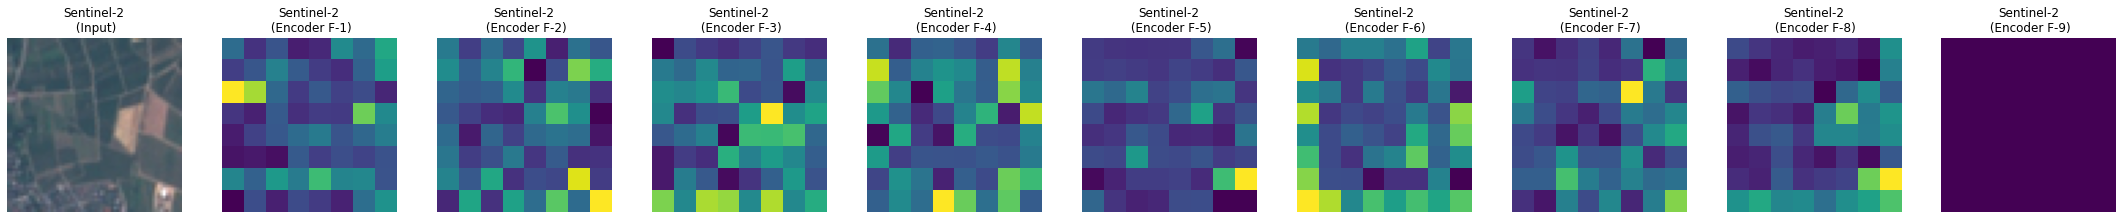

							 --------------------------- Batch 5 --------------------------- 



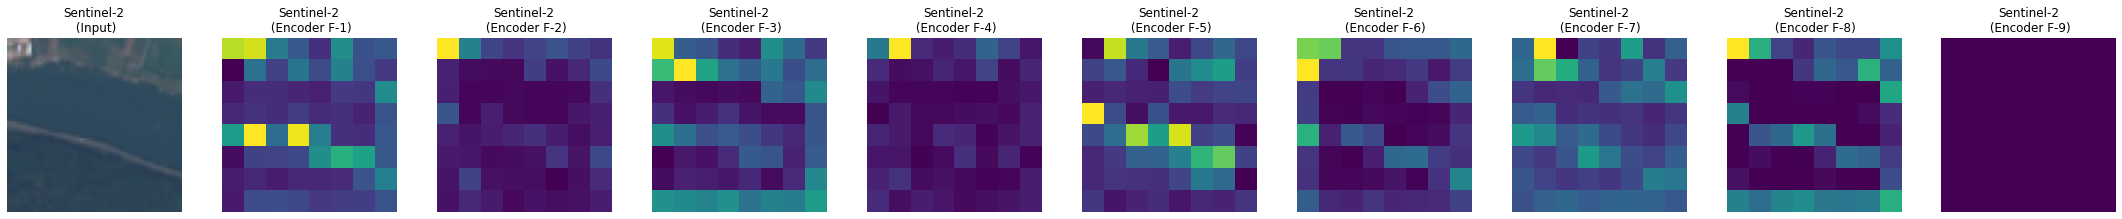

							 --------------------------- Batch 6 --------------------------- 



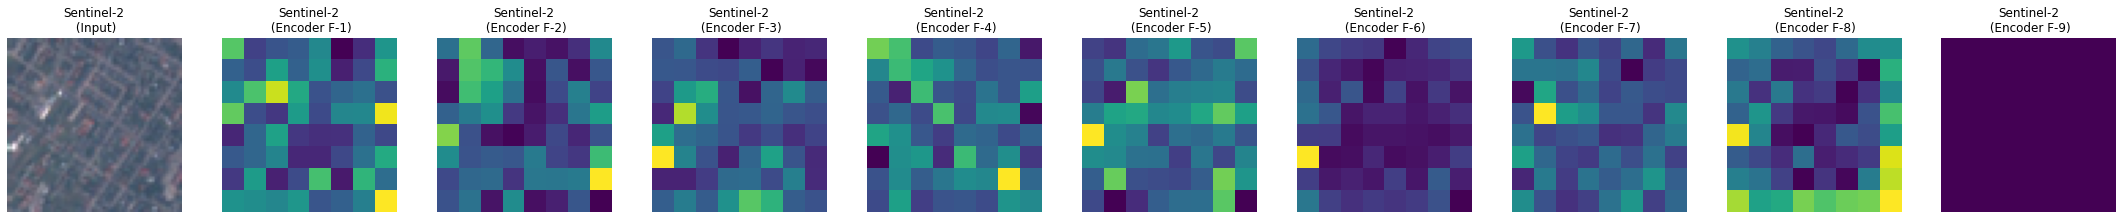

							 --------------------------- Batch 7 --------------------------- 



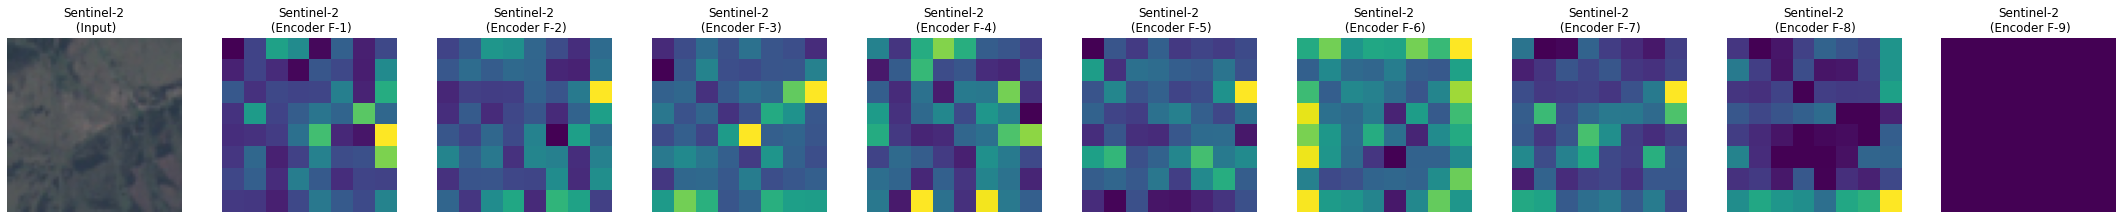

							 --------------------------- Batch 8 --------------------------- 



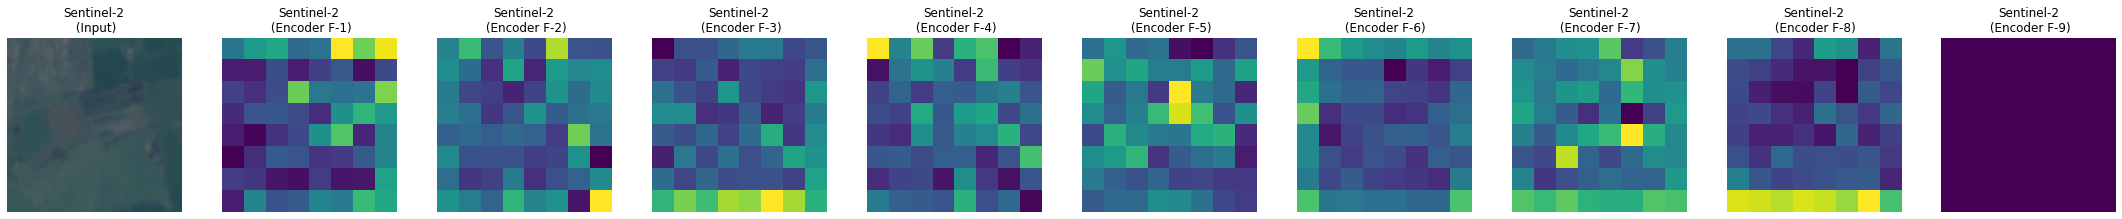

							 --------------------------- Batch 9 --------------------------- 



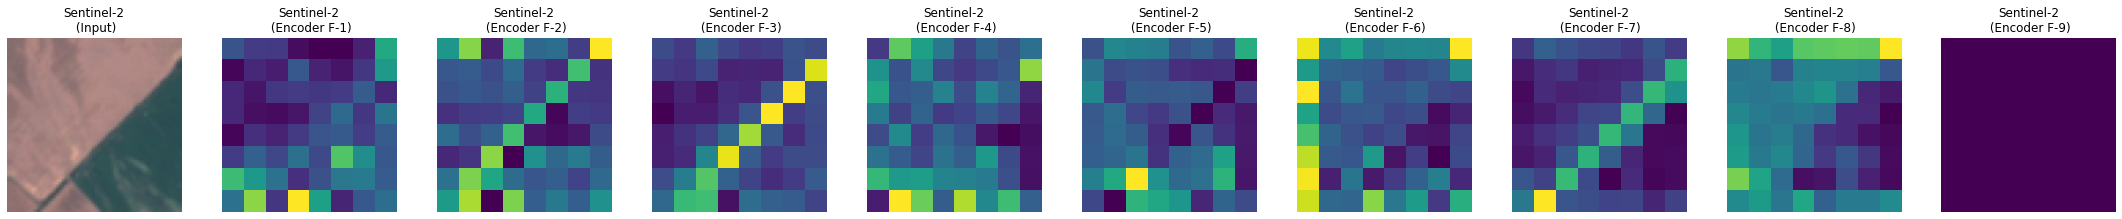

							 --------------------------- Batch 10 --------------------------- 



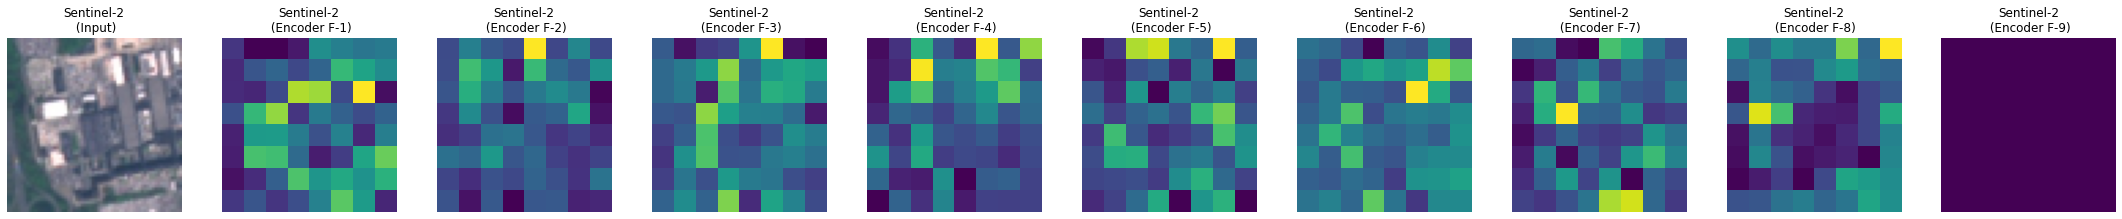

							 --------------------------- Batch 11 --------------------------- 



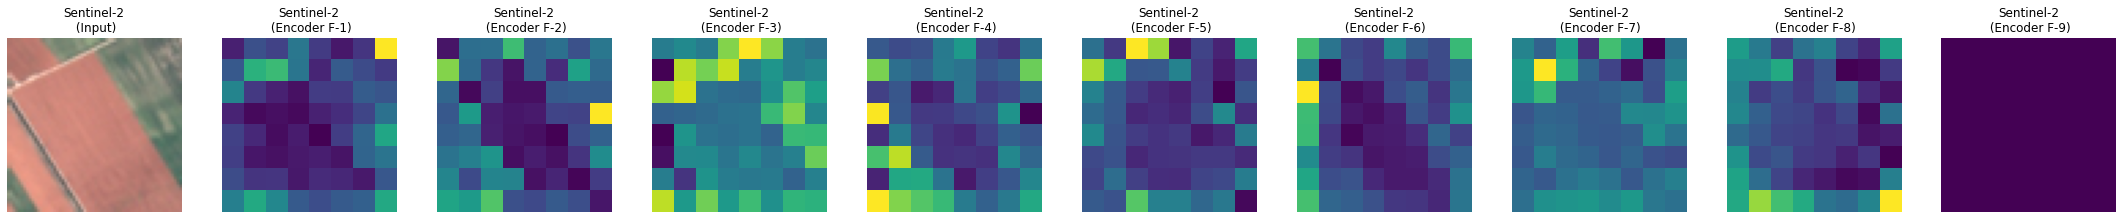

							 --------------------------- Batch 12 --------------------------- 



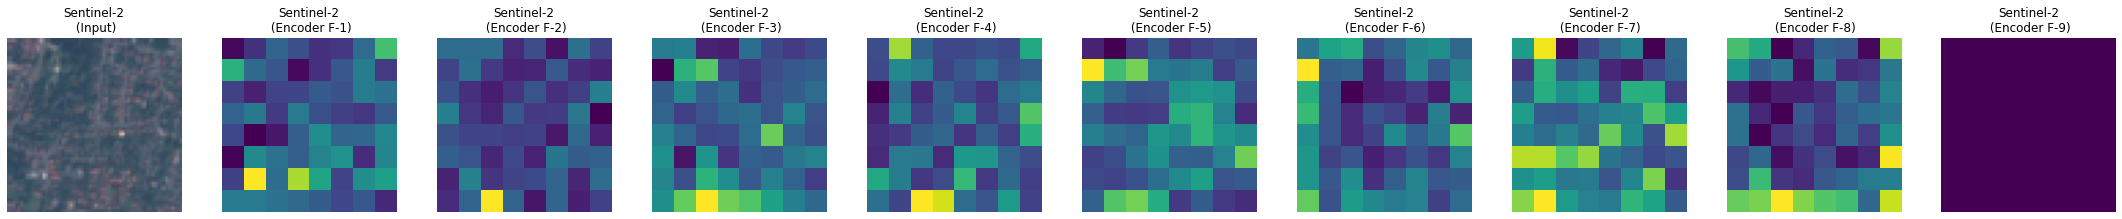

							 --------------------------- Batch 13 --------------------------- 



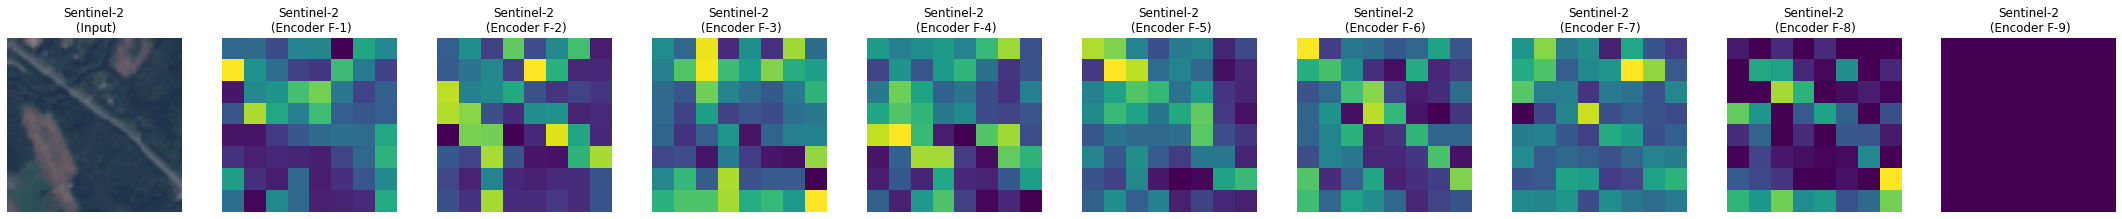

							 --------------------------- Batch 14 --------------------------- 



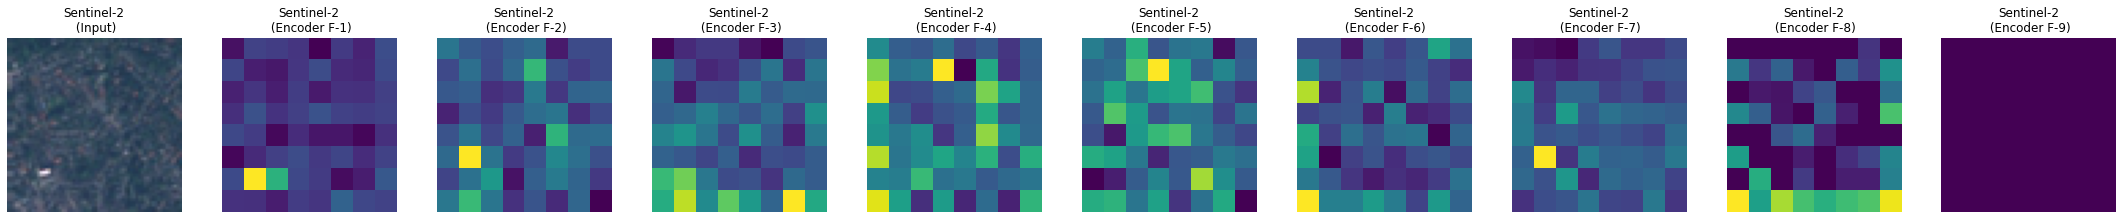

							 --------------------------- Batch 15 --------------------------- 



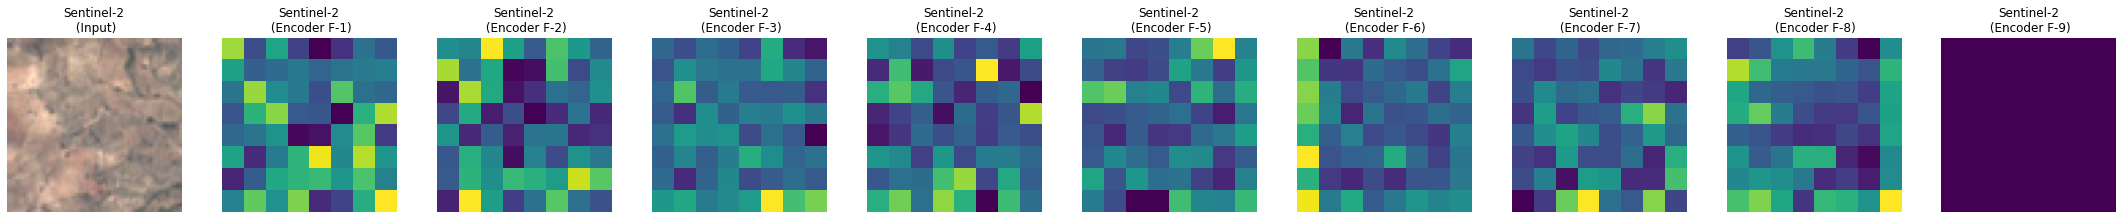

In [19]:
for i in range(batch_size):
  print('\t\t\t\t\t\t\t --------------------------- Batch {} --------------------------- \n'.format(i))

  fig, axes = plt.subplots(nrows = 1, ncols = 10, figsize = (30,3))
  axes[0].imshow(x[i])
  axes[0].axis(False)
  axes[0].set_title('Sentinel-2\n (Input)')

  for k in range(1,10):
    axes[k].imshow(y_encoder[i,:,:,k])
    axes[k].axis(False)
    axes[k].set_title('Sentinel-2\n (Encoder F-{})'.format(k))

  fig.tight_layout()
  plt.show()
  plt.close()

## Clustering

In [20]:
batch_size = 27000

train_datagen = ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/EuroSAT',  
    target_size=(64, 64),  
    batch_size=batch_size,
    class_mode='input')

Found 27000 images belonging to 10 classes.


In [21]:
x,_ = next(iter(train_generator))
y_encoder = encoder.predict(x)

K-means clustering

In [24]:
from sklearn.cluster import KMeans
y_encoder = y_encoder.reshape((27000,8*8*64))
kmeans = KMeans(n_clusters=10, random_state=0).fit(y_encoder)

In [25]:
clusters = kmeans.predict(y_encoder)

Evaluate results

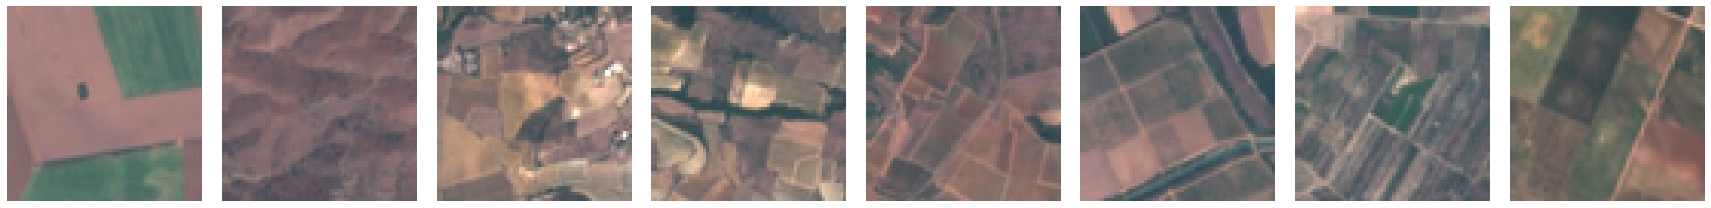

In [38]:
i = 0
j = 0

cluster = 3

fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize=(24,3))

while i < 8:

  if clusters[j] == cluster:
    axes[i].imshow(x[j])
    axes[i].axis(False)
    i += 1
  
  j+=1

fig.tight_layout()
plt.show()
    